# Install & Import Pre-requisites

In [1]:
!pip install -q -U ipykernel
!pip install -q streamlit
!pip install -q pyngrok

     |████████████████████████████████| 122kB 33.2MB/s 
     |████████████████████████████████| 788kB 28.9MB/s 
     |████████████████████████████████| 368kB 60.7MB/s 
ERROR: jupyter-console 5.2.0 has requirement prompt-toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 3.0.19 which is incompatible.
ERROR: google-colab 1.0.0 has requirement ipykernel~=4.10, but you'll have ipykernel 6.0.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement ipython~=5.5.0, but you'll have ipython 7.25.0 which is incompatible.
     |████████████████████████████████| 7.8MB 28.4MB/s 
     |████████████████████████████████| 174kB 55.9MB/s 
     |████████████████████████████████| 81kB 14.2MB/s 
     |████████████████████████████████| 112kB 64.2MB/s 
     |████████████████████████████████| 4.2MB 50.9MB/s 
     |████████████████████████████████| 71kB 11.8MB/s 
     |████████████████████████████████| 747kB 33.2MB/s 


In [2]:
from pyngrok import ngrok

In [3]:
# get token from https://dashboard.ngrok.com/get-started/your-authtoken after sign-up/in
!ngrok authtoken XXXXXXXXXXXXXXXXXXXXXXX

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


# Create Streamlit

In [152]:
%%writefile detect_and_classify.py

import torch
import streamlit as st
# from cv2 import imread, cvtColor, resize, COLOR_BGR2RGB, INTER_AREA
from PIL import Image

st.set_option('deprecation.showfileUploaderEncoding', False)
st.title('YOLOv5 COCO Object Detector')

@st.cache(allow_output_mutation=True)
def load_model():
    model = torch.hub.load('ultralytics/yolov5', 'yolov5s')
    return model

with st.spinner('Loading model into memory'):
    model = load_model()

st.sidebar.subheader('Input Method')
input_method = st.sidebar.selectbox('', ['URL', 'Upload'])
st.sidebar.subheader('Variables')
thresh = st.sidebar.slider('Threshold', 0.0, 1.0, 0.5)
iou = st.sidebar.slider('Intersection over Union', 0.0, 1.0, 0.5)


# Examples: https://ultralytics.com/images/bus.jpg; https://ultralytics.com/images/zidane.jpg, https://raw.githubusercontent.com/pjreddie/darknet/master/data/dog.jpg, https://github.com/pjreddie/darknet/blob/master/data/person.jpg
if input_method == 'URL':
    input = st.text_input('Enter Image URL to Classify...',  'https://raw.githubusercontent.com/pjreddie/darknet/master/data/dog.jpg')
elif input_method == 'Upload':
    input = st.file_uploader(label='upload image for detection', type=['png','jpg'])
else:
    st.write('Input method not handled')

if input is not None and input != '':    

    ### Model Configs ###
    model.conf = thresh # confidence threshold (0-1)
    model.iou = iou  # NMS IoU threshold (0-1)
    # model.classes = None  # (optional list) filter by class, i.e. = [0, 15, 16] for persons, cats and dogs

    # output_path = 'runs/hub/exps/'
    # img_name = input.name if input_method == 'Upload' else input.split('/')[-1]
    input = Image.open(input) if input_method == 'Upload' else input

    st.write("Predicted Class: ")
    with st.spinner('classifying...'):
        results = model(input)

    # results.save(output_path)
    # img_output_name = output_path + img_name
    # img_output = imread(img_output_name)
    # img_output = cvtColor(img_output, COLOR_BGR2RGB)
    # img_output = Image.open(img_output_name)
    img_output = Image.fromarray(results.render()[0], 'RGB')

    # h_, w_, c_ = img_output.shape
    w_, h_ = img_output.size
    w = 800
    h = int(w / w_ * h_)
    # img_output = resize(img_output, (w, h), interpolation = INTER_AREA)
    img_output = img_output.resize((w, h), Image.ANTIALIAS)

    st.image(img_output, caption='Detected Objects', use_column_width=True)
    st.write(results.pandas().xywh[0][['name','confidence','xcenter','ycenter']])

Overwriting detect_and_classify.py


# Run & Host WebApp

In [19]:
!nohup streamlit run detect_and_classify.py &

nohup: appending output to 'nohup.out'


In [20]:
url = ngrok.connect(addr=8502)
url

<NgrokTunnel: "http://dca594b653e3.ngrok.io" -> "http://localhost:8502">

In [81]:
!cat nohup.out


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8503
  External URL: http://35.194.79.32:8503

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
2021-07-12 13:02:14.459 YOLOv5 🚀 2021-7-12 torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

2021-07-12 13:02:17.864 Fusing layers... 
2021-07-12 13:02:17.952 Model Summary: 224 layers, 7266973 parameters, 0 gradients
2021-07-12 13:02:17.954 Adding AutoShape... 


## Outputs Examples

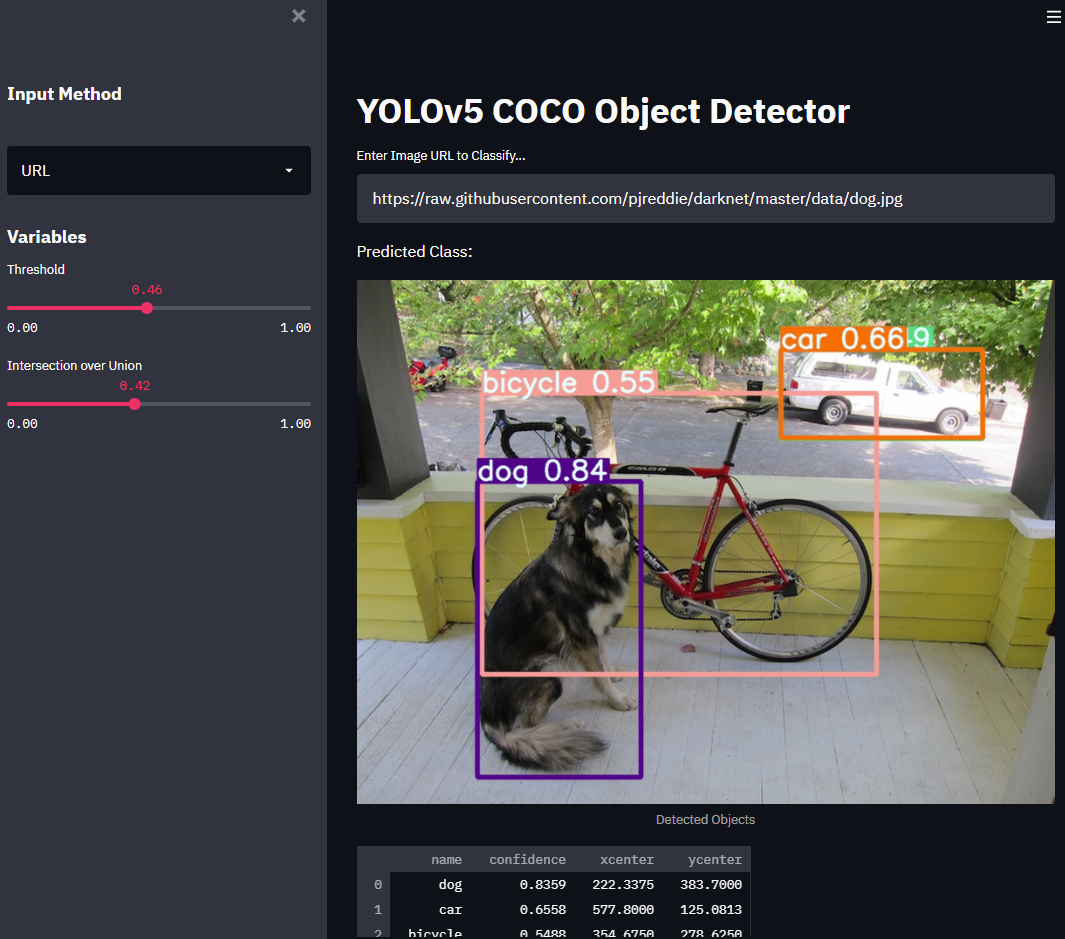

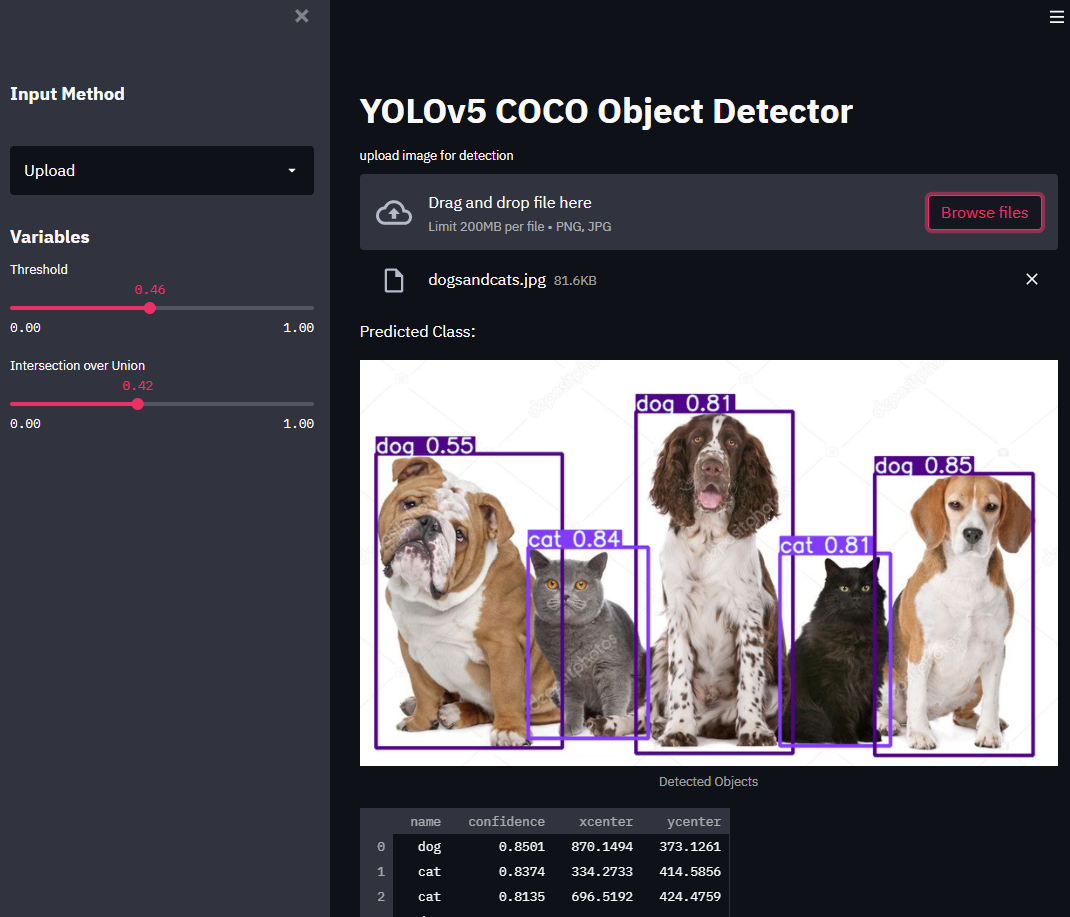

# Terminate WebApp

In [18]:
!killall ngrok
!rm nohup.out